# Table of Contents
1. [Introduction](#introduction)
2. [Environment](#environment)
    1. [Imports](#imports)
    2. [User-defined inputs](#inputs)
3. [Data Analysis](#analysis)
    1. [Auxiliary Data](#auxiliary)
    2. [Figure S4](#FigS4)
    3. [Figure 4 & Figure S3 & Auxiliary Figure](#Fig4,S3,Aux)
        1. [Figure 4](#Fig4)
        2. [Figure S3](#FigS3)
        3. [Auxiliary Figure: Connections of EPEs to Patterns for all Combinations](#FigAux)
    4. [Figure 5](#Fig5)
    5. [Figure A2 & Figure S9](#FigA2,S9)
        1. [Figure S9](#FigS9)
        2. [Figure A2](#FigA2)
    6. [Figure S2](#FigS2)
    7. [Figure 8 & Figure S6](#Fig8,S6)
        1. [Figure 8](#Fig8)
        2. [Figure S6](#FigS6)
    8. [Figure 2 & Figure S1](#Fig2,S1)
        1. [Figure 2](#Fig2)
        2. [Figure S1](#FigS1)
    9. [Figure 3](#Fig3)
    10. [Figure 1](#Fig1)
    11. [Graphical Abstract & Figures 6/A1 & Figures 7/S7 & Figures S5/S8 (ERA5/EOBS)](#GA,Fig6,7,S5)
        1. [Figures 7/S7 (ERA5 & EOBS)](#Fig7)
        2. [Figures 6/A1 (ERA5 & EOBS)](#Fig6)
        3. [Figures S5/S8 (ERA5 & EOBS)](#FigS5)
        4. [Graphical Abstract](#GA)   

# Data plotting for the work presented in the paper: <a name="introduction"></a>
### [Extreme precipitation events in the Mediterranean: Spatiotemporal characteristics and connection to large-scale atmospheric flow patterns](https://rmets.onlinelibrary.wiley.com/doi/10.1002/joc.6985)

---
Author: Nikolaos Mastrantonas\
Email: nikolaos.mastrantonas@ecmwf.int; nikolaos.mastrantonas@doktorand.tu-freiberg.de

---
This script generates all plots presented in the paper and the supplementary document, as well as some additional plots for further corroborating the findings.

# Environment<a name="environment"></a>
Load the required packages and get the user-defined inputs used for multiple plots.

## Imports<a name="imports"></a>

Import the required packages (full package or specific functions).

In [1]:
from pathlib import Path # for dictionaries/files

# basic libraries for data analysis
import numpy as np 
import pandas as pd 
import xarray as xr

# plotting functions
from matplotlib import rc

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

# functions/classes used for specific plots
from matplotlib.backends.backend_pdf import PdfPages # for multipages pdf
from matplotlib.colors import ListedColormap, BoundaryNorm # for user-defined colorbars on matplotlib
import matplotlib.lines as lines_plt
from mpl_toolkits.axes_grid1 import AxesGrid # for multiplots and nice mixing with cartopy
from cartopy.mpl.geoaxes import GeoAxes # for adding cartopy attributes to subplots
from matplotlib.image import imread
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Change the defaults for having reasonable values for publication plots.

In [2]:
rc('font', size=8)
rc('axes', labelsize=8, linewidth=0.2)
rc('legend', fontsize=6)
rc('xtick', labelsize=6)
rc('ytick', labelsize=6)
rc('lines', lw=0.5, mew=0.4)
rc('grid', linewidth=0.2)

sns.set_palette('colorblind') # change the default patette to colorblind-friendly

## User-defined inputs <a name="inputs"></a>

Define the dictionary for the input data and specify and create the subfolder for storing all data for generating the plots.

In [3]:
dir_loc = 'DataForPlots/' # the main folder where data are stored

results_loc = dir_loc + '../Figures/' # the subfolder for storing the results
Path(results_loc).mkdir(parents=True, exist_ok=True) # generate subfolder for storing the results
Path(results_loc+'Png/').mkdir(parents=True, exist_ok=True) # generate subfolder for storing png figures
Path(results_loc+'Pdf/').mkdir(parents=True, exist_ok=True) # generate subfolder for storing pdf figures

In [4]:
# naming convention and prefered order of the clusters
New_names = ['Atlantic Low', 'Biscay Low', 'Iberian Low', 'Sicilian Low', 'Balkan Low', 'Black Sea Low',
             'Mediterranean High', 'Minor Low', 'Minor High'] # naming in the final order of interest
New_order = [4, 8, 1, 6, 7, 2, 0, 3, 5] # list with the final order of each cluster

# Data Analysis <a name="analysis"></a>

## Auxiliary data<a name="auxiliary"></a>

In [5]:
# Reorder the clusters
New_order = {i:j for i, j in enumerate(New_order)}

In [6]:
# Auxiliary functions for informative colorbars

def plot_discrete_bar_inset(col_lims, col_used, data_used, ax, width, height, xlabel, cat_names, 
                            col_text='black', alpha_used=1, loc=8, brdpad=-2, bar_text_size=6):
    
    ' Categorical data: add bar plot as colorbar and include names of classes and percentage of data per class'
    
    if type(col_text) == str: col_text = [col_text]*len(col_used)
    
    ax_sub = inset_axes(ax, loc=loc, width=width, height=height, borderpad=brdpad) # create the axes of the bar

    Cl = col_lims[::-1] # reverse because barplot starts from largest to smallest
    Cu = col_used[::-1] # reverse because barplot starts from largest to smallest

    ax_sub.barh(width=Cl-Cl[-1], y=0, height=1, color=Cu, alpha=alpha_used) # plot colored bars
    ax_sub.barh(width=Cl[0]-Cl[-1], y=0, height=1,
                edgecolor='black', color='none', linewidth=.2, clip_on=False) # transparent bar with black frame

    ax_sub.set_xlim(col_lims[0], col_lims[-1]) # change the limits of the plot
    ax_sub.set_ylim(-.5, .5) # change so that colorbar covers full plot (colorbar has y=0, and height=1)
    ax_sub.set_yticks([]) # remove yticks
    
    Xticks = pd.Series(col_lims).rolling(2).mean().values[1:] # get position of ticks as middle point of each bar
    for i, j in enumerate(cat_names): # inside the bars in the Xticks locations state the provided cat_names
        ax_sub.text(s=j, x=Xticks[i], y=0, ha='center', va='center', color=col_text[i], size=bar_text_size)

    ax_sub.set_xticks(ticks=Xticks) # add the ticks in the desired locations
    ax_sub.set_xticklabels(labels=data_used, fontsize=6) # add the xticks_labels
    ax_sub.set_xlabel(xlabel, size=6) # add the final title of the bar as xlabel
    ax_sub.xaxis.set_tick_params(width=.2, length=1)
    
    return ax_sub

def plot_continuous_bar_inset(col_lims, col_used, data, ax, width, height, xlabel, loc=8, brdpad=-2):
    
    ' Continuous data: Add boxplot inside colorbar with the distribution of the studied variable for all the points'
    
    ax_sub = inset_axes(ax, loc=loc, width=width, height=height, borderpad=brdpad) # create the axes of the bar
    
    Cl = col_lims[::-1] # reverse because barplot starts from largest to smallest
    Cu = col_used[::-1] # reverse because barplot starts from largest to smallest
    
    ax_sub.barh(width=Cl-Cl[-1], y=0, height=1, left=Cl[-1], color=Cu) # plot colored bars
    ax_sub.barh(width=Cl[0]-Cl[-1], y=0, height=1, left=Cl[-1],
                edgecolor='black', color='none', linewidth=.2, clip_on=False) # transparent bar with back frame

    # plot boxplot of data; use positions=[0], so that the plot aligns with the colorbars
    ax_sub.boxplot(data, sym='x', vert=False, widths=.3, positions=[0], capprops={'linewidth': .2}, 
                    boxprops={'linewidth': .2}, flierprops={'marker': 'x', 'markersize': .3}, 
                    medianprops={'color': 'black', 'linewidth': .2}, whiskerprops={'linewidth': .2})

    ax_sub.set_ylim(-0.5, 0.5) # change so that colorbar covers full plot (colorbar has y=0, and height=1)
    ax_sub.set_yticks([]) # remove ticks of y-axis
    
    ax_sub.set_xlim(col_lims[0], col_lims[-1]) # set limits of x-axis
    ax_sub.set_xticks(col_lims) # set ticks of x axis
    ax_sub.xaxis.set_tick_params(width=.2, length=1) # change ticks visualization (same width as linewidth of barh)
    ax_sub.set_xlabel(xlabel, size=6) # set label of x-axis
    
    return ax_sub

## Figure S4<a name="FigS4"></a>

In [7]:
Frequencies = pd.read_csv(dir_loc+'Frequencies_Med_SLP~Z500.csv', index_col=0) # read data
Frequencies = Frequencies.query('Clusters=="Clusters_9"') # keep only frequencies of 9-clusters K-mean clustering
Frequencies.Cluster = Frequencies.Cluster.map(New_order) # rename the clusters based on the prefered order
Frequencies.loc[Frequencies.Season == 'All', 'Season'] = 'Annual' # change name of subset
Frequencies.rename(columns={'Occurrence (%)': 'Frequency (%)'}, inplace=True) # change name of columns

In [8]:
def adjust_box_widths(g, fac):
    
    """
    Adjust the widths of a seaborn-generated boxplot.
    Function taken from: https://stackoverflow.com/questions/56838187
    g : figure
    fac: adjustment
    """

    from matplotlib.patches import PathPatch

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

/usr/local/apps/python3/3.6.10-01/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


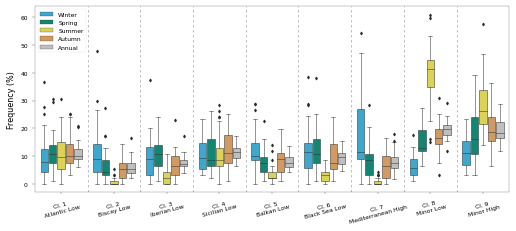

In [9]:
used_cols = [(.15, .7, .9), (0, .6, .5), (.95, .9, .25), (.9, .6, 0.3), (0.75, 0.75, 0.75)] # colorblind-friendly

fig, ax = plt.subplots(1, 1, figsize=(18/2.54, 8.1/2.54)) # define figure and dimensions

# plot data and add vertical lines seperating the clusters
sns.boxplot(data=Frequencies, x='Cluster', y='Frequency (%)', hue='Season', ax=ax,
            hue_order=['Winter', 'Spring', 'Summer', 'Autumn', 'Annual'] , palette=used_cols, 
            flierprops={'markersize': 2})
[ax.axvline(x-.5, color='black', linestyle='--', alpha=0.5, dashes=(5, 5)) for x in range(1, 9)]

# further processing of plot's elements
xticks_new = ['Cl. '+str(int(ticklabel.get_text())+1) for ticklabel in ax.get_xticklabels()] # define new tick names
xticks_new = [i_tick +'\n{}'.format(New_names[i]) for i, i_tick in enumerate(xticks_new)] # present them as 2 rows
ax.set_xticklabels(xticks_new, rotation=15) # change the tick names
ax.set_xlabel('') # remove x-label
lg = ax.legend(loc=2, handlelength=2.2) # modify legend position and length of handles
fr = lg.get_frame() # get legend frame
fr.set_lw(0.2) # modify frame's thickness
ax.xaxis.set_tick_params(width=.25, length=2) # modify x-axis ticks
ax.yaxis.set_tick_params(width=.25) # modify y-axis ticks
adjust_box_widths(fig, 0.9) # modify the boxplots, so that there is gap between the boxplots of the same x label

plt.subplots_adjust(left=0.06, bottom=0.17, right=.99, top=.98, wspace=0, hspace=0) # modify margins of figure
fig.savefig(results_loc+'Pdf/FigS4.pdf') # save figure
fig.savefig(results_loc+'Png/FigS4.png', dpi=1200, facecolor=fig.get_facecolor()) # save figure

del(used_cols, fig, ax, xticks_new, lg, fr)

In [10]:
del(Frequencies, adjust_box_widths)

## Figure 4 & Figure S3 & Auxiliary Figure<a name="Fig4,S3,Aux"></a>

Preprocessing and creation of elemenents common for both plots

In [11]:
DataSummaryAll = pd.read_csv(dir_loc+'DataSummary.csv', index_col=0) # read grid cell-wise data (median values)
DataSummaryAll.Clusters = DataSummaryAll.Clusters.str.replace('Clusters_', '') # modily names of clusters (part 1)
DataSummaryAll.Clusters = DataSummaryAll.Clusters + ' Cl.' # modily names of clusters (part 2)

Modifications for allowing categorical data having different color and shape of markers for each hue with swarmplot. Solution taken from https://stackoverflow.com/questions/52878845. Note that pointplot allows to have such options from the defaults, but it does not adjust the points for not overlapping with each other (see Aux. Figure).

In [12]:
from matplotlib.axes._axes import Axes
from matplotlib.markers import MarkerStyle

old_scatter = Axes.scatter

def GetColor2Marker(markers):
    palette = sns.color_palette()
    mkcolors = [(palette[i]) for i in range(len(markers))]
    return dict(zip(mkcolors,markers))

def fixlegend(ax,markers,markersize=8,**kwargs):
    # Fix Legend
    legtitle =  ax.get_legend().get_title().get_text()
    _,l = ax.get_legend_handles_labels()
    palette = sns.color_palette()
    mkcolors = [(palette[i]) for i in range(len(markers))]
    newHandles = [plt.Line2D([0],[0], ls="none", marker=m, color=c, mec="none", markersize=markersize,**kwargs) \
                for m,c in zip(markers, mkcolors)]
    ax.legend(newHandles,l)
    leg = ax.get_legend()
    leg.set_title(legtitle)
    fr = leg.get_frame()
    fr.set_lw(0.2) # change thickness of legend border

def new_scatter(self, *args, **kwargs):
    colors = kwargs.get("c", None)
    co2mk = kwargs.pop("co2mk",None)
    FinalCollection = old_scatter(self, *args, **kwargs)
    if co2mk is not None and isinstance(colors, np.ndarray):
        Color2Marker = GetColor2Marker(co2mk)
        paths=[]
        for col in colors:
            mk=Color2Marker[tuple(col)]
            marker_obj = MarkerStyle(mk)
            paths.append(marker_obj.get_path().transformed(marker_obj.get_transform()))
        FinalCollection.set_paths(paths)
    return FinalCollection

Axes.scatter = new_scatter

In [13]:
hue_order = ['SLP', 'T850', 'Z500', 'SLP~T850', 'SLP~Z500', 'T850~Z500', 'SLP~T850~Z500']
Markers = ['P', 's', 'o',  'v', '^', '>', '<']

x_order = [str(i)+' Cl.' for i in range(7, 13)] # order of elements on x axis

### Figure 4<a name="Fig4"></a>

In [14]:
def figure4_type(perc_used, area_used):

    # keep only the percentile of interest
    subset_used = 'P'+str(perc_used)
    DataSummary = DataSummaryAll.query('Percentile==@subset_used').copy(deep=True)
    DataSummary = pd.melt(DataSummary, value_vars=DataSummary.columns[3:-2], 
                          id_vars=['Clusters', 'Percentile', 'Type', 'Area', 'Variables'])

    titles_used = ['(a) Maximum Conditional Probability - MCP (median values)',
                   '(b) Percentage of EPEs in the cluster of MCP (median values)']

    fig, ax = plt.subplots(1, 2, figsize=(18/2.54, 6.5/2.54))
    ax = ax.flatten()

    for i_c, i_var in enumerate(['MCP', 'MCP_PercExtr']):
        data_used = DataSummary.query('variable==@i_var and Area==@area_used')
        plt_i = sns.swarmplot(data=data_used, y='value', x='Clusters', hue='Variables', 
                              ax=ax[i_c], size=6, order=x_order, hue_order=hue_order, co2mk=Markers)
        ax[i_c].set_ylabel('(%)')
        ax[i_c].set_xlabel('')
        ax[i_c].set_title(titles_used[i_c], loc='left', size=7)
        
        [ax[i_c].axvline(x-.5, color='black', linestyle='--', alpha=0.5, dashes=(5, 5)) 
         for x in range(1, len(hue_order))]
        
        ax[i_c].xaxis.set_tick_params(width=.25, length=2)
        ax[i_c].yaxis.set_tick_params(width=.25)
        
        if i_c == 0:
            ax[i_c].legend().set_title('')
            fixlegend(ax[i_c], Markers, markersize=6)
        else:
            plt_i.get_legend().remove()

    plt.subplots_adjust(left=0.07, bottom=0.08, right=.99, top=.9, wspace=0.15, hspace=0.25)
    
    return fig

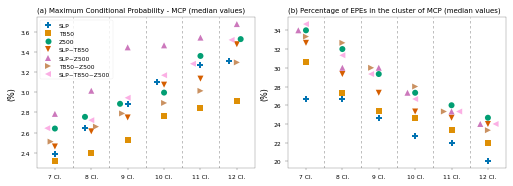

In [15]:
Fig4 = figure4_type(perc_used=99, area_used='Med')
Fig4.savefig(results_loc+'Pdf/Fig4.pdf')
Fig4.savefig(results_loc+'Png/Fig4.png', dpi=1200, facecolor=Fig4.get_facecolor())
del(Fig4)

### Figure S3<a name="FigS3"></a>

In [16]:
def figureS3_type(perc_used, area_used):
    
    # keep only the percentile of interest
    subset_used = 'P'+str(perc_used)
    DataSummary = DataSummaryAll.query('Percentile==@subset_used').copy(deep=True)
    DataSummary = pd.melt(DataSummary, value_vars=DataSummary.columns[3:-2], 
                          id_vars=['Clusters', 'Percentile', 'Type', 'Area', 'Variables'])

    fig, ax = plt.subplots(1,2, figsize=(18/2.54, 6.5/2.54))
    ax = ax.flatten()

    plt_0 = sns.swarmplot(data=DataSummary.query('variable=="PercentSign" and Area==@area_used'), y='value', 
                          x='Clusters', hue='Variables', size=6, order=x_order, hue_order=hue_order, 
                          co2mk=Markers, ax=ax[0])
    ax[0].set_title('(a) Percentage of grid cells with significant connections', size=7, loc='left')

    plt_1 = sns.swarmplot(data=DataSummary.query('variable=="TotalPercSign" and Area==@area_used'), y='value', 
                          x='Clusters', hue='Variables', size=6, order=x_order, hue_order=hue_order, 
                          co2mk=Markers, ax=ax[1])
    plt_1.get_legend().remove() # remove legend from 2nd plot (it will be presented in 1st plot only)
    ax[1].set_title('(b) Percentage of EPEs for sign. connections (median values)', loc='left', size=7)

    for i in range(2):
        ax[i].set_ylabel('(%)')
        ax[i].set_xlabel('')
        [ax[i].axvline(x-.5, color='black', linestyle='--', alpha=0.5, dashes=(5, 5)) 
         for x in range(1, len(hue_order))]
        ax[i].xaxis.set_tick_params(width=.25, length=2)
        ax[i].yaxis.set_tick_params(width=.25)

    ax[0].legend().set_title('')
    fixlegend(ax[0], Markers, markersize=6)

    plt.subplots_adjust(left=0.07, bottom=0.08, right=.99, top=.9, wspace=0.15, hspace=0.25)
    
    return fig

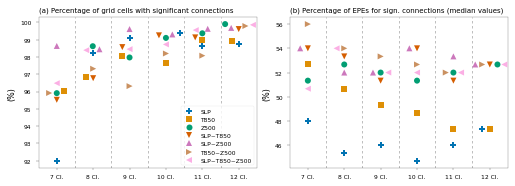

In [17]:
FigS3 = figureS3_type(perc_used=99, area_used='Med')
FigS3.savefig(results_loc+'Pdf/FigS3.pdf')
FigS3.savefig(results_loc+'Png/FigS3.png', dpi=1200, facecolor=FigS3.get_facecolor())
del(FigS3)

### Auxiliary Figure: Connections of EPEs to Patterns for all Combinations<a name="FigAux"></a>

Auxiliary Figure for checking the performance of derived patterns and connections to EPEs for the different Areas and Used atmospheric variables. This is in order to justify that "Med" is the prefered one, as it stands out from all other areas for all studied percentiles. Especially so for SLP~Z500 & 9 Clusters K-means in the Maximum Conditional Probability.

In [18]:
data_plot = DataSummaryAll.copy(deep=True)
data_plot['Nominal'] = [100-int(i[1:]) for i in data_plot['Percentile']] # numeric of nominal probability
data_plot['MCP_over_Nominal'] = data_plot['MCP']/data_plot['Nominal'] # ratio of MCP over nominal

Areas_n = len(data_plot.Area.unique()) # number of unique Areas

In [19]:
data_plot = DataSummaryAll.copy(deep=True)
data_plot['Nominal'] = [100-int(i[1:]) for i in data_plot['Percentile']] # numeric of nominal probability
data_plot['MCP_over_Nominal'] = data_plot['MCP']/data_plot['Nominal'] # ratio of MCP over nominal

Areas_n = len(data_plot.Area.unique()) # number of unique Areas
Vars_all = ['MCP_over_Nominal', 'PercentSign', 'MCP_PercExtr', 'TotalPercSign']
Titles_all = ['Max. Cond. Prob. over Nominal (median values  of sign. locations)', 
              'Percentage of grid cells with significant connections',
              'Percentage of EPEs assigned to the MCP cluster (median values of locations with sign. connections)',
              'Percetange of EPEs sign. connected to any cluster (median values of locations with sign. connections)']

out_f = results_loc+'Pdf/Aux_Connections_AllResults.pdf'
with PdfPages(out_f) as pdf:
    for var_used, title_used in zip(Vars_all, Titles_all):
        plt_aux = sns.catplot(data=data_plot, y=var_used, x='Area', row='Clusters', col='Percentile',
                              kind='point', markers=Markers, dodge=.5, join=False,
                              hue='Variables', hue_order=hue_order, margin_titles=True, legend=False)

        for ax in plt_aux.axes.flatten():
            [i_col.set_sizes([20]) for i_col in ax.collections] # change size of points
            [ax.axvline(x-.5, color='black', linestyle='--', alpha=0.5, dashes=(5, 5)) for x in range(1, Areas_n)] 
            
        plt.legend(ncol=4, bbox_to_anchor=(-2.1, 7.25), loc=2).set_title('')
        
        plt_aux.fig.set_size_inches(18/2.54, 24/2.54)
        plt_aux.fig.suptitle(title_used, size=8, fontweight="bold")
        plt.subplots_adjust(top=0.93)
        
        pdf.savefig(bbox_inches='tight')
        plt.close()
    
del(data_plot, Areas_n, Vars_all, Titles_all, out_f, var_used, title_used, plt_aux, ax)

In [20]:
Axes.scatter = old_scatter # convert back to the original function of Axes.scatter

del(x_order, Markers, hue_order, GetColor2Marker, fixlegend, new_scatter, old_scatter, DataSummaryAll,
    figure4_type, figureS3_type)

## Figure 5<a name="Fig5"></a>

In [21]:
Composites = xr.open_dataarray(dir_loc+'ClusteringComposites_Med_SLP~Z500_Clusters9.nc')
    
Composites = Composites.assign_coords({'cluster': pd.Series(Composites.cluster).map(New_order).values}) # map
Composites = Composites.sortby('cluster') # reorder

In [22]:
Labels = pd.read_csv(dir_loc+'Clusters_Med_SLP~Z500.csv', index_col=0)['Clusters_9']
Labels = Labels.map(New_order)
Climat_Frequencies = Labels.value_counts()/len(Labels)*100
Climat_Frequencies = Climat_Frequencies.reindex(range(9))

In [23]:
title_aux = list(map(chr, range(97, 123)))[:9] # alphabetic order for subplots naming
Colors_used = sns.color_palette('RdBu_r', n_colors=15)
Colors_used= Colors_used[:5]+['white']+Colors_used[-5:]
Colors_used = ListedColormap(Colors_used)
Colors_limits = [-16, -13, -10, -7, -4, -1, 1, 4, 7, 10, 13, 16] # levels for the colors (actual abs. max is 15.7)
Cont_levels = np.linspace(-24, 24, 13) # act. max is 21.2

X, Y = np.meshgrid(Composites.longitude, Composites.latitude)
Max_values = np.abs(Composites).max(dim=['cluster', 'latitude', 'longitude']).values
Max_values = np.round(Max_values/np.array([100, 98.1]), 2)
print('Absolute Max values for SLP and Z500 are {} hPa and {} dam respectively'.format(Max_values[0], Max_values[1]))

Absolute Max values for SLP and Z500 are 15.7 hPa and 21.14 dam respectively


/usr/local/apps/python3/3.6.10-01/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/usr/local/apps/python3/3.6.10-01/lib/python3.6/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


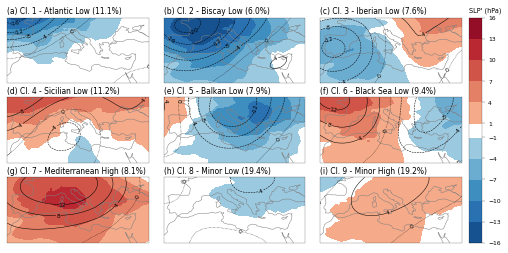

In [24]:
axes_class = (GeoAxes, dict(map_projection=ccrs.PlateCarree()))
fig = plt.figure(figsize=(18/2.54, 9.1/2.54))
grid = AxesGrid(fig, 111, nrows_ncols=(3,3), axes_pad=.2,
                cbar_mode='single', cbar_location='right', cbar_pad=.1,
                axes_class=axes_class, cbar_size='3%', label_mode='')

for i, ax in enumerate(grid):

    ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree()) # set extent
    ax.outline_patch.set_linewidth(.2) # reduce the border thickness
    
    ax.coastlines(resolution='110m', linewidth=.5, color='grey') # add coastline

    contf = ax.contourf(X, Y, Composites.sel(variable='SLP', cluster=i)/100, # plot contourf for SLP anomalies
                        transform=ccrs.PlateCarree(), levels=Colors_limits, cmap=Colors_used) 
    cont = ax.contour(X, Y, Composites.sel(variable='Z500', cluster=i)/98.1, # plot contour for Z500 anomalies
                      transform=ccrs.PlateCarree(),levels=Cont_levels, colors='black') 
    ax.clabel(cont, inline=1, fontsize=6, fmt='%d')
    for line, lvl in zip(cont.collections, cont.levels):
        if lvl == 0:
            line.set_linestyle(':')

    ax.set_title('({}) Cl. {} - {} ({:.1f}%)'.format(title_aux[i], i+1, New_names[i], Climat_Frequencies[i]), 
                 pad=4, size=7.5, loc='left')

cbar = ax.cax.colorbar(contf, ticks=Colors_limits, spacing='equal') # add colorbar
cbar.ax.set_title("SLP' (hPa)", size=6.5, loc='left')
cbar.ax.yaxis.set_tick_params(width=.25, length=3)

plt.subplots_adjust(left=0.02, bottom=0.01, right=.95, top=.96)
fig.savefig(results_loc+'Pdf/Fig5.pdf')
fig.savefig(results_loc+'Png/Fig5.png', dpi=1200, transparent=True)

del(fig, axes_class, grid, i, ax, contf, cont, line, lvl, cbar)

In [25]:
del(Composites, Labels, Climat_Frequencies, title_aux, Colors_used, Colors_limits, Cont_levels, X, Y, Max_values)

## Figure A2 & Figure S9<a name="FigA2,S9"></a>

In [26]:
EOBS_Overlap = xr.open_dataarray(dir_loc+'Overlap_ERA5_EOBS.nc')  

X, Y = np.meshgrid(EOBS_Overlap.longitude.values, EOBS_Overlap.latitude.values)

### Figure S9<a name="FigS9"></a>

Data with the locations of stations used for EOBS dataset are available at: https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php. For the analysis the version v.21.0e of precipitation data was used, so the relevant file name is: https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/stations_info_tx_v21.0e.txt

In [27]:
# EOBS_locs = 'https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/stations_info_rr_v21.0e.txt'
# EOBS_locs = pd.read_csv(EOBS_locs, sep='|', index_col=0)
' For some reason the above data retrieval from the website is not working, so the data are saved in txt file '
EOBS_locs = pd.read_csv(dir_loc+'EOBS_locs.txt', sep='|', index_col=0)

EOBS_locs.columns = [ i.strip() for i in EOBS_locs.columns]
EOBS_locs.STOP = EOBS_locs.STOP.str.strip()
# for some reason some dates have day ending on 31st for months with 30 days, so just convert all ending days to 28
EOBS_locs.STOP = [''.join([date[:-2]]+['28']) for date in EOBS_locs.STOP.values] 

EOBS_locs.START = pd.to_datetime(EOBS_locs.START.str.strip())
EOBS_locs.STOP = pd.to_datetime(EOBS_locs.STOP)

Min_X, Max_X = X.min()-2, X.max()+2
Min_Y, Max_Y = Y.min()-2, Y.max()+2

EOBS_locs = EOBS_locs.query('LAT >= @Min_Y & LAT <= @Max_Y & LON >= @Min_X & LON <= @Max_X')
stop_min = pd.to_datetime('1979-01-01') # use any station that has data for at least 1 day between 1979-2019
EOBS_locs = EOBS_locs.query('STOP >= @stop_min')
start_max = pd.to_datetime('2019-12-31') # use any station that has data for at least 1 day between 1979-2019
EOBS_locs = EOBS_locs.query('START <= @start_max')

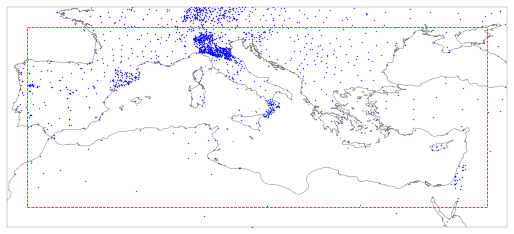

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(18/2.54, 8.5/2.54), subplot_kw=dict(projection=ccrs.PlateCarree())) 
ax.set_extent([Min_X, Max_X, Min_Y, Max_Y], crs=ccrs.PlateCarree())
ax.outline_patch.set_linewidth(.2) # reduce the border thickness
ax.coastlines(resolution='10m', linewidth=0.5, color='grey')
sns.scatterplot(data=EOBS_locs, x='LON', y='LAT', color='blue', linewidth=0, ax=ax, s=2, alpha=.7) 
rect = plt.Rectangle((X.min(), Y.min()),X.max()-X.min(), Y.max()-Y.min(), fill=False, color='red', linestyle='--',
                     linewidth=.75) 
ax.add_patch(rect) # add rectangle with the actual area used for the Precipitation analysis
plt.subplots_adjust(left=0.01, bottom=0.005, right=.99, top=.995)
fig.savefig(results_loc+'Pdf/FigS9.pdf')
fig.savefig(results_loc+'Png/FigS9.png', dpi=1200, transparent=True)

del(EOBS_locs, Min_X, Max_X, Min_Y, Max_Y, stop_min, start_max, fig, ax, rect)

### Figure A2<a name="FigA2"></a>

In [29]:
NANs = EOBS_Overlap[0] # get locations of NANs(lat/lon) from first slice of xarray
NANs = np.isnan(NANs)
    
Cols_used = sns.color_palette('mako_r', n_colors=10) 
# Cols_used = sns.color_palette('tab20', n_colors=10) # more easy to distinguish but does not print well at grayscale

title_aux = list(map(chr, range(97, 123)))[:24] # alphabetic order for subplots naming       

/usr/local/apps/python3/3.6.10-01/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


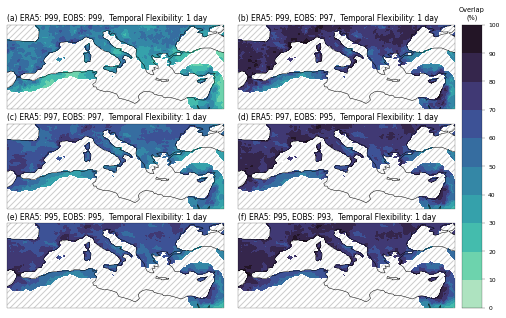

In [30]:
fig = plt.figure(figsize=(18/2.54, 12/2.54))
axes_class = (GeoAxes, dict(map_projection=ccrs.PlateCarree()))
grid = AxesGrid(fig, 111, nrows_ncols=(3, 2), axes_pad=.2,
                cbar_mode='single', cbar_location='right', cbar_pad=.1,
                axes_class=axes_class, cbar_size='3%', label_mode='')

for i, ax in enumerate(grid):

    ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree()) # set extent
    ax.outline_patch.set_linewidth(.2) # reduce the border thickness
    
    ax.coastlines(resolution='110m', linewidth=.5, color='black') # add coastline
               
    plot_overlap = ax.contourf(X, Y, EOBS_Overlap[i], zorder=1, transform=ccrs.PlateCarree(), 
                               cmap=ListedColormap(Cols_used), levels=np.arange(0, 101, 10))
    
    # pre-processing for getting the information of the combination of EOBS and ERA5 extremes
    Input_comb = EOBS_Overlap.Input_comb.values[i] 
    Input_comb = Input_comb.split(',')
    ERA5_P = Input_comb[0][-2:] 
    EOBS_P = Input_comb[1][-2:] 
    wn_ex = int(Input_comb[2][1:-1] )
    title_used = '({}) ERA5: P{}, EOBS: P{},  Temporal Flexibility: {}'.\
                        format(title_aux[i], ERA5_P, EOBS_P, wn_ex)
    title_used = title_used + ' day' if wn_ex in [0, 1] else title_used + ' days'
    ax.set_title(title_used, pad=4, size=7.5, loc='left')

    plt_NANs = ax.contourf(X, Y, NANs.where(NANs==True), hatches=['////'], colors='white')
    plt_NANs.collections[0].set_edgecolor('.8')
    plt_NANs.collections[0].set_linewidth(0.) 
    
    
cbar = ax.cax.colorbar(plot_overlap, ticks=np.arange(0, 101, 10), spacing='equal')
cbar.ax.set_title("Overlap\n(%)", size=6.5, loc='center')
cbar.ax.yaxis.set_tick_params(width=.25, length=3)

plt.subplots_adjust(left=0.02, bottom=0.01, right=.95, top=.96)
fig.savefig(results_loc+'Pdf/FigA2.pdf')
fig.savefig(results_loc+'Png/FigA2.png', dpi=1200, transparent=True)

del(fig, axes_class, grid, i, ax, plot_overlap, Input_comb, ERA5_P, EOBS_P, wn_ex, title_used, cbar, plt_NANs)

In [31]:
del(EOBS_Overlap, X, Y, Cols_used, title_aux, NANs)

## Figure S2<a name="FigS2"></a>

In [32]:
EOFs_SLP = xr.open_dataarray(dir_loc+'ComponentsEOF_Med_SLP.nc')
EOFs_SLP = -EOFs_SLP # it happened that SLP & Z500 EOFs have reverse signs; for visualisation make them same sign
VARs_SLP = np.loadtxt(dir_loc+'VarianceEOF_Med_SLP.out')    
EOFs_Z500 = xr.open_dataarray(dir_loc+'ComponentsEOF_Med_Z500.nc')
VARs_Z500 = np.loadtxt(dir_loc+'VarianceEOF_Med_Z500.out')    

In [33]:
title_aux = list(map(chr, range(97, 123)))[:13] # alphabetic order for subplots naming
Colors_used = sns.color_palette('RdBu_r', n_colors=12)
Colors_used = ListedColormap(Colors_used)
Colors_limits = np.linspace(-0.09, 0.09, 13) # levels for the colors (actual abs. max is 0.086)
X, Y = np.meshgrid(EOFs_SLP.longitude, EOFs_SLP.latitude)
Max_value = max(np.abs(EOFs_SLP).max(), np.abs(EOFs_Z500).max())
print('The absolute Max values for both variables is {:.3f}'.format(Max_value.values))

The absolute Max values for both variables is 0.086


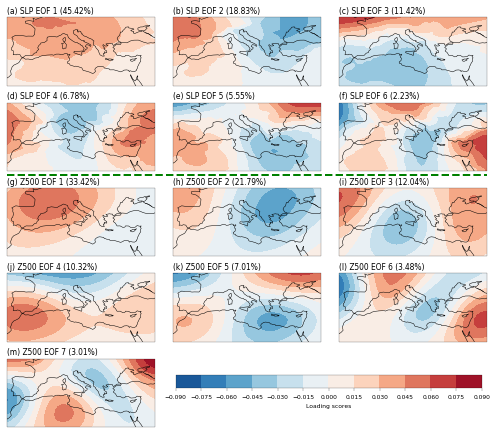

In [34]:
fig, ax_all = plt.subplots(5, 3, figsize=(18/2.54, 15.2/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
ax_all = ax_all.flatten()

for i, ax in enumerate(ax_all):
    
    ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree()) # set extent
    ax.outline_patch.set_linewidth(.2) # reduce the border thickness
    
    if i<6: # plot initially the SLP EOFs
        
        ax.coastlines(resolution='110m', linewidth=.5, color='black') # add map
        
        plot_eof = ax.contourf(X, Y, EOFs_SLP.isel(mode=i), zorder=1, 
                               transform=ccrs.PlateCarree(), cmap=Colors_used, levels=Colors_limits)

        ax.set_title('({}) SLP EOF {} ({:.2f}%)'.format(title_aux[i], i+1, VARs_SLP[i]), 
                     pad=4, loc='left', size=7.5)

    elif i<13: # plot the Z500 EOFs
        
        ax.coastlines(resolution='110m', linewidth=.5, color='black') # add map
        
        plot_eof = ax.contourf(X, Y, EOFs_Z500.isel(mode=i-6),
                               transform=ccrs.PlateCarree(), cmap=Colors_used, levels=Colors_limits)
                
        ax.set_title('({}) Z500 EOF {} ({:.2f}%)'.format(title_aux[i], i-6+1, VARs_Z500[i-6]), 
                     pad=4, loc='left', size=7.5)
        
    else: # plot empty and transparent space for all remaining subplots
        ax.outline_patch.set_visible(False)
        ax.background_patch.set_visible(False)
        
cbaxes = fig.add_axes([0.36, 0.1, 0.6, 0.03])
cbar = plt.colorbar(plot_eof, ticks=Colors_limits, orientation='horizontal', cax=cbaxes)
cbar.ax.tick_params(width=.25, length=3)
cbar.ax.set_xlabel('Loading scores', size=6)

fig.add_artist(lines_plt.Line2D([0.03, .97], [.595, .595], linestyle='--', color='green', linewidth=2)) # sep. line

plt.subplots_adjust(left=0.02, bottom=0.01, right=.98, top=.96, hspace=0.25, wspace=0.05)
fig.savefig(results_loc+'Pdf/FigS2.pdf')
fig.savefig(results_loc+'Png/FigS2.png', dpi=1200, transparent=True)

del(fig, ax_all, i, ax, plot_eof, cbaxes, cbar)

In [35]:
del(EOFs_SLP, VARs_SLP, EOFs_Z500, VARs_Z500, title_aux, Colors_used, Colors_limits, X, Y, Max_value)

## Figure 8 & Figure S6<a name="Fig8,S6"></a>

In [36]:
SpatiotemporalOverlap = xr.open_dataarray(dir_loc+'SpatiotemporalOverlap.nc')

In [37]:
colors_used = ['white'] + sns.color_palette('mako_r', n_colors=9) 
colors_used = ListedColormap(colors_used)

X, Y = np.meshgrid(SpatiotemporalOverlap.longitude, SpatiotemporalOverlap.latitude)

In [38]:
def plot_connections(i_cell, ax, percentile=99, extend_used=None):
    
    # read data
    data = SpatiotemporalOverlap.sel(percentile=percentile).isel(coordinates=i_cell) # read the final data
    Coords = SpatiotemporalOverlap.coordinates.values[i_cell] # get coordinates
    Coords = Coords.split(', ')
    Lat, Lon = [float(i[4:]) for i in Coords] # get lat, lon of the target cell
    Coords = pd.DataFrame({'Lon': [Lon], 'Lat': [Lat]})
    
    # plot the data
    projection_used = ccrs.PlateCarree() # projection to be used

    if extend_used != None:
        ax.set_extent(extend_used, crs=projection_used)
    
    ax.outline_patch.set_linewidth(.2) # reduce the border thickness
    
    ax.coastlines(resolution='10m', linewidth=.5, color='lightgray') # add coastline

    plot_perc = ax.contourf(X, Y, data, transform=projection_used, 
                            cmap=colors_used, levels=np.linspace(0,100,11))
    sns.scatterplot(data=Coords, x='Lon', y='Lat', color='red', ax=ax, s=200, marker='x', linewidth=.75)

    return plot_perc

### Figure 8<a name="Fig8"></a>

/usr/local/apps/python3/3.6.10-01/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  


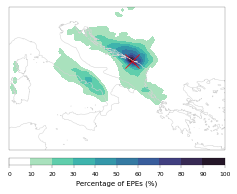

In [39]:
fig = plt.figure(figsize=(8/2.54, 7/2.54))
axes_class = (GeoAxes, dict(map_projection=ccrs.PlateCarree()))
grid = AxesGrid(fig, 111, nrows_ncols=(1,1), axes_pad=.1, cbar_mode='single', cbar_location='bottom', 
                cbar_pad=.0, axes_class=axes_class, cbar_size='5%', label_mode='')

plot_con = plot_connections(0, grid[0], percentile=99, extend_used=[8, 26, 35, 47])

cbar = grid[0].cax.colorbar(plot_con, spacing='equal', ticks=np.linspace(0,100,11))
cbar.ax.xaxis.set_tick_params(width=.25, length=3)
plt.xlabel('Percentage of EPEs (%)', size=7)

plt.subplots_adjust(left=0.02, bottom=0.13, right=.97, top=.96)
fig.savefig(results_loc+'Pdf/Fig8.pdf')
fig.savefig(results_loc+'Png/Fig8.png', dpi=1200, transparent=True)

del(fig, axes_class, grid, plot_con, cbar)

### Figure S6<a name="FigS6"></a>

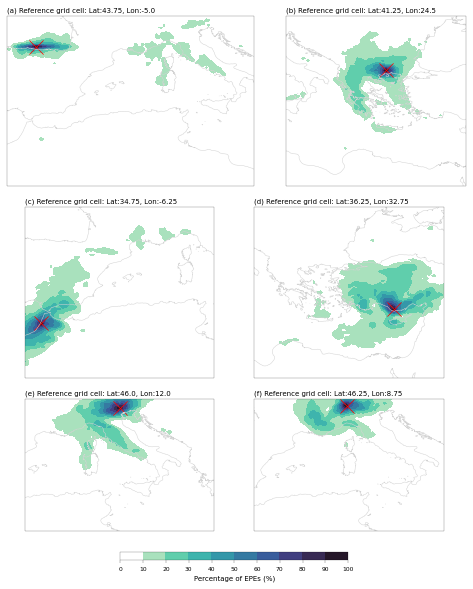

In [40]:
title_aux = list(map(chr, range(97, 123)))[:24] # alphabetic order for subplots naming   
Areas_used = [[-8, 18, 29, 47], [14, 33, 29, 47], [-8, 12, 29, 47] ,[18, 38, 29, 47], 
              [2, 22, 33, 47], [-1, 19, 33, 47]]


fig = plt.figure(figsize=(18/2.54, 21/2.54))
gs = fig.add_gridspec(58, 45)
ax1 = fig.add_subplot(gs[1:19, :26], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1:19, 26:], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[21:39, 2:22], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[21:39, -22:-2], projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[41:55, 2:22], projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[41:55, -22:-2], projection=ccrs.PlateCarree())

ax_all = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, ax in enumerate(ax_all):

    plot_con = plot_connections(i+1, ax, percentile=99, extend_used=Areas_used[i])
    ax.set_title('({}) Reference grid cell: {}'.format(title_aux[i], SpatiotemporalOverlap.coordinates.values[i+1]), 
                 pad=4, loc='left', size=7)
    
axes = fig.add_subplot(gs[57:, 12:-12])
cbar = plt.colorbar(plot_con, cax=axes, orientation='horizontal', ticks=np.linspace(0,100,11))
cbar.ax.xaxis.set_tick_params(width=.25, length=3)
plt.xlabel('Percentage of EPEs (%)', size=7)

plt.subplots_adjust(left=0.02, bottom=0.05, right=.98, top=.98)
fig.savefig(results_loc+'Pdf/FigS6.pdf')
fig.savefig(results_loc+'Png/FigS6.png', dpi=1200, transparent=True)

del(title_aux, Areas_used, fig, gs, ax1, ax2, ax3, ax4, ax5, ax6, ax_all, i, ax, axes, plot_con, cbar)

In [41]:
del(SpatiotemporalOverlap, colors_used, X, Y, plot_connections)

## Figure 2 & Figure S1<a name="Fig2,S1"></a>

In [42]:
# the season dimensions refers to Seasons: 1-4 for Winter-Autumn
Seasonality = xr.open_dataarray(dir_loc+'Seasonality.nc') 
X, Y = np.meshgrid(Seasonality.longitude, Seasonality.latitude)
X_grid2 = np.abs(np.diff(Seasonality.longitude)[0])/2 # when using imshow/pcolor, extend must be adjust so it ...
Y_grid2 = np.abs(np.diff(Seasonality.latitude)[0])/2 # ... covers all boundary, as the coords refer to the center

'''
It seems that for some reason imshow has a slight shift of the data so the pcolor is used instead.
Nevertheless, pcolor defines each location as lower left corner, and does not plot the last column & row, so some
auxiliary data need to be created to overcome this issue, and use pcolor for generating accurate figures.
Possible explanation of imshow error: https://github.com/matplotlib/matplotlib/issues/12934
''' 

Aux = np.zeros(np.array(Seasonality.shape[-2:])+1) # dimensions of lat/lon

X_all = Aux.copy()
X_all[:, :-1] = X[0, :]
X_all[:, -1] = X.max()+X_grid2*2
X_all -= X_grid2 # shift the data so each location refers to the center and not the edge
Y_all = Aux.copy()
Y_all[1:, :] = Y[:,0][..., np.newaxis]
Y_all[0, :] = Y.max()+Y_grid2*2
Y_all -= Y_grid2 # shift the data so each location refers to the center and not the edge

del(Aux, X_grid2, Y_grid2)

### Figure 2<a name="Fig2"></a>

In [43]:
# sort seasons based on frequency of extremes per gridcell. Sort descending ([::-1] at the end)
SeasonsSorted = Seasonality.groupby('percentile').apply(lambda x: x.argsort(axis=0)[::-1])
SeasonsSorted = SeasonsSorted.assign_coords({'season': range(1, 5)}) # names in the correct order
SeasonsSorted = SeasonsSorted.rename({'season': 'season_order'}) # change name of dimensin   

In [44]:
def seasonality(perc_used):
    
    SeasonsSorted_perc = SeasonsSorted.sel(percentile=perc_used) # get the data for the percentile of interest
    
    Cols_used = [(.15, .7, .9),(0, .6, .5),(.95, .9, .25),(.9, .6, 0.3)] # colorblind-friendly & "related" to seasons
    titles_used = ['(a) Season of Highest Occurrence of EPEs at each grid cell', 
                   '(b) Season of 2$^{nd}$ Highest Occurrence of EPEs at each grid cell']

    fig, ax_all = plt.subplots(2, 1, figsize=(8/2.54, 10/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    for i_c, ax in enumerate(ax_all): 

        ax.coastlines(resolution='110m', linewidth=.5, color='black')
        ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())
        ax.outline_patch.set_linewidth(.2) # reduce the border thickness

        Data_used = SeasonsSorted_perc.isel(season_order=i_c)

        plot_max = ax_all[i_c].pcolor(X_all, Y_all, Data_used, transform=ccrs.PlateCarree(),
                                      cmap=ListedColormap(Cols_used), vmin=0, vmax=4) # 0-3: Winter-Autumn

        ax_all[i_c].set_title(titles_used[i_c], loc='left', size=7, pad=2)

        # get the values per season so that the statistics are created and plotted on the colorbar
        SeasonMaxValues = Data_used.values.flatten()        
        Counts = pd.Series(SeasonMaxValues).value_counts()
        Counts = Counts.reindex(np.arange(5)).fillna(0) # sort data per season and fill 0 seasons with no occurrence
        Counts = np.round(Counts/len(SeasonMaxValues)*100, 2).astype(str)

        ax_sub = plot_discrete_bar_inset(col_lims=np.arange(5), col_used=Cols_used, data_used=Counts.values, 
                                col_text='black', ax=ax_all[i_c], brdpad=-2.5, loc=8, 
                                cat_names=['Winter', 'Spring', 'Summer', 'Autumn'],
                                width='100%', height='15%', xlabel='Percentage of grid cells (%)')

    plt.subplots_adjust(left=0.02, bottom=0.1, right=.98, top=.99)    
    return fig

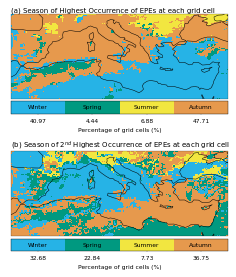

In [45]:
Fig2 = seasonality(perc_used=99)
Fig2.savefig(results_loc+'Pdf/Fig2.pdf')
Fig2.savefig(results_loc+'Png/Fig2.png', dpi=1200, transparent=True)

del(Fig2)

### Figure S1<a name="FigS1"></a>

In [46]:
def seasonality_all(perc_used):

    Cols_used = sns.color_palette('GnBu', n_colors=10)

    fig, ax_all = plt.subplots(2, 2, figsize=(18/2.54, 10.5/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    # plot the percentage of extremes at each season
    for i, j in enumerate(range(1, 5)):

        ax_all[i].coastlines(resolution='110m', linewidth=.5, color='black')
        ax_all[i].set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())
        ax_all[i].outline_patch.set_linewidth(.2) # reduce the border thickness

        data_used = Seasonality.sel(percentile=perc_used, season=j)
        plot_i = ax_all[i].contourf(X, Y, data_used, transform=ccrs.PlateCarree(), 
                                    cmap=ListedColormap(Cols_used), levels=np.linspace(0,100,11))
        ax_all[i].set_title(['(a) Winter', '(b) Spring', '(c) Summer', '(d) Autumn'][i], pad=3, size=7, loc='left')

        x_label = 'Percentage of EPEs (%)'
        data_used = data_used.values.flatten() # flatten the data for using on the colorbar
        ax_sub = plot_continuous_bar_inset(col_lims=np.linspace(0, 100, 11), col_used=Cols_used, data=data_used, 
                                           ax=ax_all[i], width='100%', height='15%', 
                                           loc=8, brdpad=-2.5, xlabel=x_label)

    fig.subplots_adjust(left=0.02, bottom=0.1, right=.98, top=.99, wspace=.1, hspace=.2)
    return fig

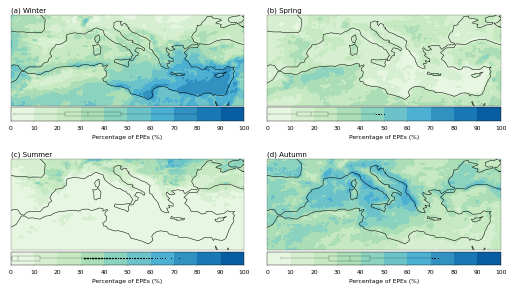

In [47]:
FigS1 = seasonality_all(perc_used=99)
FigS1.savefig(results_loc+'Pdf/FigS1.pdf')
FigS1.savefig(results_loc+'Png/FigS1.png', dpi=1200, transparent=True)
del(FigS1)    

In [48]:
del(Seasonality, X, Y, X_all, Y_all, SeasonsSorted, seasonality, seasonality_all)

## Figure 3<a name="Fig3"></a>

In [49]:
TemporalDependencies = xr.open_dataarray(dir_loc+'TemporalDependencies.nc') 

X, Y = np.meshgrid(TemporalDependencies.longitude, TemporalDependencies.latitude)
lags_depend_sets = TemporalDependencies.temporal_lag.values

In [50]:
def temporal_dependencies(percentile_used):
    
    TemporalDependencies_used = TemporalDependencies.sel(percentile=percentile_used) # data of percentile of interest
    max_dependency = TemporalDependencies_used.max().values
    max_dependency = np.ceil(max_dependency/10)*10 # round the max value to the upper ceiling multiple of 10

    title_aux = ['('+letter+') ' for letter in list(map(chr, range(97, 123)))[:len(lags_depend_sets)] ] # titles aux
    title_suf = ['day' if i_lag == 1 else 'days' for i_lag in lags_depend_sets]

    Cols_used = sns.color_palette('YlGnBu', n_colors=10) 

    fig, ax_all = plt.subplots(2, 2, figsize=(18/2.54, 10.5/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    for i_c in range(len(lags_depend_sets)):

        ax_all[i_c].coastlines(resolution='110m', linewidth=.5, color='black')
        ax_all[i_c].set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())
        ax_all[i_c].outline_patch.set_linewidth(.2) # reduce the border thickness

        temp_depend = TemporalDependencies_used.isel(temporal_lag=i_c)
        plot_i = ax_all[i_c].contourf(X, Y, temp_depend, transform=ccrs.PlateCarree(), cmap=ListedColormap(Cols_used),
                                      levels=np.linspace(0, max_dependency, 11))

        title_used = title_aux[i_c]+'Maximum Temporal Interval: {} {}'.format(lags_depend_sets[i_c], title_suf[i_c])
        ax_all[i_c].set_title(title_used, pad=3, size=7, loc='left')

        ax_sub = plot_continuous_bar_inset(col_lims=np.linspace(0, max_dependency, 11), 
                                           col_used=Cols_used, ax=ax_all[i_c], data=temp_depend.values.flatten(), 
                                           loc=8, width='100%', height='15%', 
                                           brdpad=-2.5, xlabel='Percentage of EPEs (%)')

    fig.subplots_adjust(left=0.02, bottom=0.1, right=.98, top=.99, wspace=.1, hspace=.2)
    
    return fig

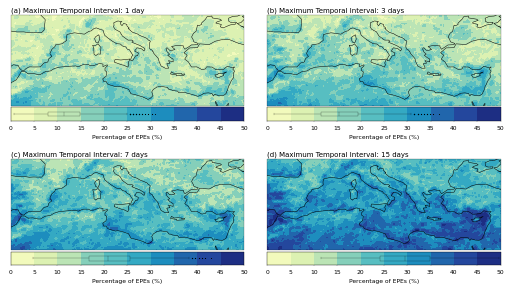

In [51]:
Fig3 = temporal_dependencies(percentile_used=99)
Fig3.savefig(results_loc+'Pdf/Fig3.pdf')
Fig3.savefig(results_loc+'Png/Fig3.png', dpi=1200, transparent=True)
del(Fig3)

In [52]:
del(TemporalDependencies, X, Y, lags_depend_sets, temporal_dependencies)

## Figure 1<a name="Fig1"></a>

Orography data are downloaded from https://www.naturalearthdata.com/downloads/10m-raster-data/10m-cross-blend-hypso/, and the section of "Cross Blended Hypso with Relief, Water, Drains, and Ocean Bottom"; file name: *HYP_LR_SR_OB_DR* (medium size resolution)

In [53]:
Threshold = xr.open_dataarray(dir_loc+'ThresholdsEPEs.nc')
X, Y = np.meshgrid(Threshold.longitude, Threshold.latitude)

In [54]:
def orography_intensities(percentile_used):
    
    Threshold_used = Threshold.sel(percentile=percentile_used) # subset the percentile of interest
    max_intensity = Threshold_used.max().values
    max_intensity = np.ceil(max_intensity/10)*10 # round the max value to the upper ceiling multiple of 10

    fig, ax_all = plt.subplots(2, 1, figsize=(8/2.54, 8.6/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    for ax in ax_all: # set for all subplots the extent
        ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())
        ax.outline_patch.set_linewidth(.2) # reduce the border thickness

    fname = dir_loc + '../Data/HYP_LR_SR_OB_DR.tif'
    ax_all[0].imshow(imread(fname), origin='upper', extent=[-180, 180, -90, 90])
    ax_all[0].set_title('(a) Cross-blended Hypsometric Tints', pad=4, size=7, loc='left')

    Cols_used = sns.color_palette('GnBu', n_colors=10)
    ax_all[1].coastlines(resolution='10m', linewidth=.5, color='grey') # add cartopy map with coast deliniation
    ax_all[1].contourf(X, Y, Threshold_used, transform=ccrs.PlateCarree(), 
                       cmap=ListedColormap(Cols_used), vmin=0, vmax=90)
    ax_all[1].set_title('(b) EPEs threshold', pad=4, size=7, loc='left')

    plot_continuous_bar_inset(col_lims=np.linspace(0, max_intensity, 11), col_used=Cols_used, 
                              data=Threshold_used.values.flatten(),
                              ax=ax_all[1], width='100%', height='15%', loc=8, brdpad=-2.5, 
                              xlabel='Daily precipitation (mm)' )

    plt.subplots_adjust(left=0.02, bottom=0.12, right=.98, top=.97, hspace=.005)
    
    return fig

/usr/local/apps/python3/3.6.10-01/lib/python3.6/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (131220000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


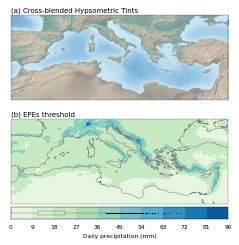

In [55]:
Fig1 = orography_intensities(percentile_used=99)
Fig1.savefig(results_loc+'Pdf/Fig1.pdf', dpi=1200) # 1200 dpi so that the subplot a) has good resolution
Fig1.savefig(results_loc+'Png/Fig1.png', dpi=1200, transparent=True) 
del(Fig1)

In [56]:
del(Threshold, X, Y, orography_intensities)

## Graphical Abstract & Figures 6/A1 & Figures 7/S7 & Figures S5/S8 (ERA5/EOBS)<a name="GA,Fig6,7,S5"></a>

In [57]:
ClustersStatsAll = {}
ClustersStatsAll['ERA5'] = xr.open_dataarray(dir_loc+'ClusteringStats_Med_SLP~Z500_Clusters9.nc') 
ClustersStatsAll['EOBS'] = xr.open_dataarray(dir_loc+'ClusteringStats_Med_SLP~Z500_Clusters9_EOBS.nc') 

# remap clusters based on user-defined ordering
ClustersStatsAll = {name: data.assign_coords({'cluster': pd.Series(data.cluster).map(New_order).values}) 
                    for name, data in ClustersStatsAll.items()}
ClustersStatsAll = {name: data.sortby('cluster') for name, data in ClustersStatsAll.items()}

# domains for ERA5 and EOBS are the same
X, Y = np.meshgrid(ClustersStatsAll['ERA5'].longitude, ClustersStatsAll['ERA5'].latitude)
X_grid2 = np.abs(np.diff(ClustersStatsAll['ERA5'].longitude)[0])/2 # when using imshow/pcolor, adjust extend ...
Y_grid2 = np.abs(np.diff(ClustersStatsAll['ERA5'].latitude)[0])/2 # ... as the coords refer to the center not edges

'''
It seems that for some reason imshow has a slight shift of the data so the pcolor is used instead.
Nevertheless, pcolor defines each location as lower left corner, and does not plot the last column & row, so some
auxiliary data need to be created to overcome this issue, and use pcolor for generating accurate figures.
Possible explanation of imshow error: https://github.com/matplotlib/matplotlib/issues/12934
''' 
Aux = np.zeros(np.array(ClustersStatsAll['ERA5'].shape[-2:])+1) # dimensions of lat/lon

X_all = Aux.copy()
X_all[:, :-1] = X[0, :]
X_all[:, -1] = X.max()+X_grid2*2
X_all -= X_grid2 # shift the data so each location refers to the center and not the edge
Y_all = Aux.copy()
Y_all[1:, :] = Y[:,0][..., np.newaxis]
Y_all[0, :] = Y.max()+Y_grid2*2
Y_all -= Y_grid2 # shift the data so each location refers to the center and not the edge
del(Aux, X_grid2, Y_grid2)

Reorder xarray data based on multiple conditions. There is surely a more simple way to do it...

In [58]:
# reorder numpy array on mupltiple conditions
def sort_data(slice_used):
    
    """ 
    Sort data based on multiple conditions: sorting from min to max with the following importance from most important 
    to least: significance (-1, 0, 1), cond prob, perc extremes, cond prob lower quantile
    """
    test_sort = np.lexsort((slice_used[3], slice_used[2], slice_used[1], slice_used[0]))
    
    return test_sort[::-1] # from max to min

In [59]:
# convert reordered np array back to xr dataarray
def np_to_xr(np_array, indicator_name):
    
    XR = xr.DataArray(data=np_array,
                        dims=['order', 'latitude', 'longitude'],
                        coords={'order': range(np_array.shape[0]), 
                                'latitude': ClustersStatsAll['ERA5'].latitude.values,
                                'longitude': ClustersStatsAll['ERA5'].longitude.values})

    XR = XR.assign_coords({'indicator': indicator_name})
    
    return XR

In [60]:
# reorder actual xarray data per each percentile
def reorder_data(data_used, percentile):
    
    Data_sort = data_used.sel(indicator=['Significance', 'CondProb', 'PercExtremes', 'CondProbUpperLimit'])
    Data_sort = Data_sort.values

    Sorted_data = Data_sort[0,:].copy()
    Sorted_data[:] = np.nan
    for i_y in range(Sorted_data.shape[1]):
        for i_x in range(Sorted_data.shape[2]):
            Sorted_data[:, i_y, i_x] = sort_data(slice_used=Data_sort[:, :, i_y, i_x])

    Sorted_data = Sorted_data.astype(int) # convert the indices to integer
    Ratio_Sorted = np.take_along_axis(data_used.sel(indicator='PercExtremes').values, Sorted_data, 0)
    Cond_Sorted = np.take_along_axis(data_used.sel(indicator='CondProb').values, Sorted_data, 0)
    Cond_to_Nom_Sort = Cond_Sorted/(100-percentile) # ratio of cond. over nominal for comparing accross percentiles
    Sign_Sorted = np.take_along_axis(data_used.sel(indicator='Significance').values, Sorted_data, 0)
    Sign_Sorted = (Sign_Sorted==1)*1 # boolean with 1/0 for statistical significance or not

    Sorted_data = np_to_xr(Sorted_data, 'Cluster')
    Ratio_Sorted = np_to_xr(Ratio_Sorted, 'PercExtremes')
    Cond_Sorted = np_to_xr(Cond_Sorted, 'CondProb')
    Cond_to_Nom_Sort = np_to_xr(Cond_to_Nom_Sort, 'Cond_over_Nom')
    Sign_Sorted = np_to_xr(Sign_Sorted, 'Significance')

    Ordered_xr = xr.concat([Sorted_data, Ratio_Sorted, Cond_Sorted, Cond_to_Nom_Sort, Sign_Sorted], dim='indicator')

    return Ordered_xr

In [61]:
# create final reordered xr dataarrays for all data
ClustersReordered = {}
ClustersReordered['ERA5'] = [reorder_data(ClustersStatsAll['ERA5'].sel(percentile=i_p), i_p) 
                             for i_p in ClustersStatsAll['ERA5'].percentile.values]
ClustersReordered['EOBS'] = [reorder_data(ClustersStatsAll['EOBS'].sel(percentile=i_p), i_p) 
                             for i_p in ClustersStatsAll['EOBS'].percentile.values]

for name in ClustersReordered:
    ClustersReordered[name] = xr.concat(ClustersReordered[name], 
                                        dim=pd.Index(ClustersStatsAll[name].percentile.values, name='percentile'))
    
del(name, sort_data, np_to_xr, reorder_data)

Get the ratio of Conditional Probs over Nominal Probs from ERA5 data, and find the min and max value of the significant locations.

In [62]:
Cond_over_Nom = ClustersReordered['ERA5'].sel(indicator='Cond_over_Nom')
Sign = ClustersReordered['ERA5'].sel(indicator='Significance')

min_cond_prob = (Cond_over_Nom.where(Sign==1)).min()
min_cond_prob = np.floor(min_cond_prob).values

max_cond_prob = (Cond_over_Nom.where(Sign==1)).max()
max_cond_prob = np.ceil(max_cond_prob).values

Cond_cols_used = sns.color_palette('pink_r', n_colors=11)
Cond_vals_used = np.linspace(min_cond_prob, max_cond_prob, len(Cond_cols_used)+1)

Cond_colorbar = {}
Cond_colorbar['ERA5'] = {'Colors': Cond_cols_used, 'Values': Cond_vals_used}

del(Cond_over_Nom, Sign, min_cond_prob, max_cond_prob, Cond_cols_used, Cond_vals_used)

In [63]:
Cond_over_Nom = ClustersReordered['EOBS'].sel(indicator='Cond_over_Nom')
Sign = ClustersReordered['EOBS'].sel(indicator='Significance')

min_cond_prob = (Cond_over_Nom.where(Sign==1)).min()
min_cond_prob = np.floor(min_cond_prob).values

max_cond_prob = (Cond_over_Nom.where(Sign==1)).max()
max_cond_prob = np.ceil(max_cond_prob).values

# use same colorscale as the ERA5 equivalent figure (Figure 6)
Cond_cols_used = Cond_colorbar['ERA5']['Colors']
Cond_vals_used = Cond_colorbar['ERA5']['Values']

# if the min value is lower than ERA5 min, then add light grey color and append the value at the start of the array
if min_cond_prob<Cond_vals_used.min(): 
    Cond_cols_used = ['.95'] + Cond_cols_used 
    Cond_vals_used = np.insert(Cond_vals_used, 0, min_cond_prob)

# if the max value is lower than ERA5 min, then add darkred color and append the value at the end of the array
if max_cond_prob>Cond_vals_used.max(): 
    Cond_cols_used = Cond_cols_used + ['darkred']
    Cond_vals_used = np.insert(Cond_vals_used, len(Cond_vals_used), max_cond_prob)

Cond_colorbar['EOBS'] = {'Colors': Cond_cols_used, 'Values': Cond_vals_used}

del(Cond_over_Nom, Sign, min_cond_prob, max_cond_prob, Cond_cols_used, Cond_vals_used)

In [64]:
Cl_vals_used = np.arange(10)
# Cl_cols_used = sns.color_palette()[:9]
# Cl_cols_used[1] = 'cyan' # change the 2nd color, since the original one is similar to other ones of the palette
Cl_cols_used = [(.02, 0.40, 0.55), (.0, 0.75, 0.7), (.0, 0.63, 0.4), (.85, 0.35, 0.1), (.8, 0.5, 0.75), 
                (.7, 0.5, 0.45), (1, 0.7, 0.75), (.65, 0.65, 0.65), (.95, 0.95, 0.2)]

### Figures 7/S7 (ERA5 & EOBS)<a name="Fig7"></a>

In [65]:
def Fig7_type(dataset_used, perc_used):
    
    CondProb = ClustersStatsAll[dataset_used].sel(indicator='CondProb', percentile=perc_used).copy(deep=True)
    Sign = ClustersStatsAll[dataset_used].sel(indicator='Significance', percentile=perc_used).copy(deep=True)

    NANs = ClustersStatsAll[dataset_used][0][0][0] # get locations of NANs(lat/lon) from first slice of xarray
    NANs = np.isnan(NANs)
    all_locs_len = (NANs==0).sum().values # locations after excluding areas of NaN (check script 3 for EOBS)

    # letters for subplots titles
    title_aux = list(map(chr, range(97, 123)))[:len(ClustersStatsAll[dataset_used].cluster)] 
    
    Cond_cols_used = Cond_colorbar[dataset_used]['Colors']
    # values for cond prob and not ratio Cond/Nom.
    Cond_vals_used = Cond_colorbar[dataset_used]['Values']*(100-perc_used) 
    
    fig, ax_all = plt.subplots(3, 3, figsize=(18/2.54, 12/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    for i_c, ax in enumerate(ax_all):
        ax.coastlines(resolution='110m', linewidth=.5, color='black')
        ax.outline_patch.set_linewidth(.2) # reduce the border thickness
        ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())

        data_mesh = CondProb.sel(cluster=i_c).values
        data_mesh[(Sign.sel(cluster=i_c)!=1)] = -.5
        
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        ax.pcolor(X_all, Y_all, data_mesh, transform=ccrs.PlateCarree(), 
                  norm=BoundaryNorm(np.insert(Cond_vals_used, 0, -1), len(Cond_cols_used)+1),  
                  cmap=ListedColormap(['white']+Cond_cols_used))  
        Perc_Sign_Locs = (Sign.sel(cluster=i_c) == 1).sum()/all_locs_len*100 # number of significant locations
        Perc_Sign_Locs = np.round(Perc_Sign_Locs.values, 2) # % locs that cluster is significant

        naming_convension = str(i_c+1) + " - {}".format(New_names[i_c])
        ax.set_title('({}) Cl. {} ({}%)'.format(title_aux[i_c], naming_convension, Perc_Sign_Locs), 
                     pad=2, size=7, loc='left')
        
        # add informative colorbar
        values_used = data_mesh.flatten()[~(Sign.sel(cluster=i_c) != 1).values.flatten()] # only significant locs
        plot_continuous_bar_inset(col_lims=Cond_vals_used, col_used=Cond_cols_used, data=values_used, ax=ax, 
                                  width='100%', height='15%', loc=8, brdpad=-2, xlabel='Conditional Probability (%)')

        if (NANs==True).sum()>0: # hatch NaN locs (only valid for EOBS data)
            plt_NANs = ax.contourf(X, Y, NANs.where(NANs==True), hatches=['////'], colors='white')
            plt_NANs.collections[0].set_edgecolor('.8')
            plt_NANs.collections[0].set_linewidth(0.)  

    plt.subplots_adjust(left=0.02, bottom=0.05, right=.98, top=.99, hspace=.05, wspace=0.1)
    return fig

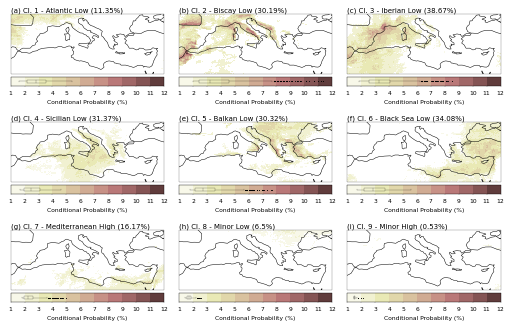

In [66]:
Fig7 = Fig7_type(dataset_used='ERA5', perc_used=99)
Fig7.savefig(results_loc+'Pdf/Fig7.pdf')
Fig7.savefig(results_loc+'Png/Fig7.png', dpi=1200, transparent=True)

del(Fig7)

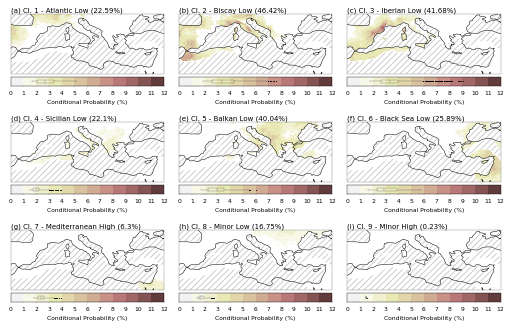

In [67]:
FigS7 = Fig7_type(dataset_used='EOBS', perc_used=99)
FigS7.savefig(results_loc+'Pdf/FigS7.pdf')
FigS7.savefig(results_loc+'Png/FigS7.png', dpi=1200, transparent=True)
del(FigS7)

### Figures 6/A1 (ERA5 & EOBS)<a name="Fig6"></a>

In [68]:
def Fig6_type(dataset_used, perc_used):
    
    data_used = ClustersReordered[dataset_used].copy(deep=True)
    
    NANs = ClustersStatsAll[dataset_used][0][0][0] # get locations of NANs(lat/lon) from first slice of xarray
    NANs = np.isnan(NANs)

    all_locs_len = (NANs==0).sum().values # locations after excluding areas of NaN (check script 3 for EOBS)
    
    Cond_cols_used = Cond_colorbar[dataset_used]['Colors']
    # values for cond prob and not ratio Cond/Nom.
    Cond_vals_used = Cond_colorbar[dataset_used]['Values']*(100-perc_used) 
    
    fig, ax_all = plt.subplots(3, 2, figsize=(18/2.54, 16.5/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    # plot the best 2 clusters for each location
    for i, j in enumerate([0,1]):

        cluster_data_actual = data_used.sel(indicator='Cluster', order=i, percentile=perc_used).values
        cluster_data = cluster_data_actual+1 # add one so that all clusters have integer positive values
        Sign_Sorted = data_used.sel(indicator='Significance', order=i, percentile=perc_used).values
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        cluster_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
        cluster_plot = ax_all[j].pcolor(X_all, Y_all, cluster_data, transform=ccrs.PlateCarree(), 
                                        norm=BoundaryNorm(np.insert(Cl_vals_used+1, 0, -1), len(Cl_cols_used)+1), 
                                        cmap=ListedColormap(['white']+Cl_cols_used)) # same idea as Figure 7


        sign_values = cluster_data_actual.flatten()[~(Sign_Sorted != 1).flatten()] # keep only significant locations
        sign_perc = np.round(len(sign_values)/all_locs_len*100, 1)
        title_used = ['(a)', '(b)'][i] 
        title_used += ' Cluster of {} highest condit. prob. (sign. at {:.1f}% of grid cells)'.\
                       format(['', '2$^{nd}$'][i], sign_perc)
        ax_all[j].set_title(title_used, size=7, pad=2, loc='left')
        
        # add informative colorbar
        Counts = pd.Series(sign_values).value_counts()
        Counts = Counts.reindex(Cl_vals_used[:-1]).fillna(0)
        Counts = np.round(Counts/all_locs_len*100, 1).astype(str)
        plot_discrete_bar_inset(col_lims=Cl_vals_used, col_used=Cl_cols_used, data_used=Counts, 
                                ax=ax_all[j], brdpad=-3, loc=8,
                                cat_names=['Cl. '+str(i) for i in list(Cl_vals_used[1:])], col_text='black',
                                width='100%', height='15%', xlabel='Percentage of grid cells (%)')


    # plot conditional probabilities of the best 2 clusters for each location
    for i, j in enumerate([2,3]): 

        cond_data = data_used.sel(indicator='CondProb', order=i, percentile=perc_used).values
        Sign_Sorted = data_used.sel(indicator='Significance', order=i, percentile=perc_used).values
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        cond_data[Sign_Sorted!=1] = -.5 # mask no sign locations with negative value
        cond_plot = ax_all[j].pcolor(X_all, Y_all, cond_data, transform=ccrs.PlateCarree(), 
                                     norm=BoundaryNorm(np.insert(Cond_vals_used, 0, -1), len(Cond_cols_used)+1),
                                     cmap=ListedColormap(['white']+Cond_cols_used)) 

        title_used = ['(c)', '(d)'][i] 
        title_used += ' Conditional probablitity of EPEs for the clusters of subplot {}'.format(['a', 'b'][i])
        ax_all[j].set_title(title_used, size=7, pad=2, loc='left')

        # add informative colorbar
        cond_values = cond_data.flatten()[~(Sign_Sorted != 1).flatten()]
        plot_continuous_bar_inset(col_lims=Cond_vals_used, col_used=Cond_cols_used, data=cond_values, ax=ax_all[j], 
                                  width='100%', height='15%', loc=8, brdpad=-3, xlabel='Conditional Probability (%)')


    # plot % of EPE for the best 2 clusters for each location
    Perc_vals_used = np.linspace(0, 100, 11) # Percentages plot between 0-100% with 10 colors   
    Perc_cols_used = sns.color_palette('YlGnBu', n_colors=10)
    for i, j in enumerate([4,5]):

        ratio_data = data_used.sel(indicator='PercExtremes', order=i, percentile=perc_used).values
        Sign_Sorted = data_used.sel(indicator='Significance', order=i, percentile=perc_used).values
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        ratio_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
        perc_plot = ax_all[j].pcolor(X_all, Y_all, ratio_data, transform=ccrs.PlateCarree(), 
                                     norm=BoundaryNorm(np.insert(Perc_vals_used, 0, -1), len(Perc_vals_used)+1),
                                     cmap=ListedColormap(['white']+Perc_cols_used)) 


        title_used = ['(e)', '(f)'][i] + ' Percentage of EPEs for the clusters of subplot {}'.format(['a', 'b'][i])
        ax_all[j].set_title(title_used, size=7, pad=2, loc='left')
        
        # add informative colorbar
        perc_values = ratio_data.flatten()[~(Sign_Sorted != 1).flatten()]
        plot_continuous_bar_inset(col_lims=Perc_vals_used, col_used=Perc_cols_used, data=perc_values, ax=ax_all[j], 
                                  width='100%', height='15%', loc=8, brdpad=-3, xlabel='Percentage of EPEs (%)')    

    for ax in ax_all: # set for all subplots the cartopy map and the extent
        if (NANs==True).sum()>0: # hatch NaN locs (only valid for EOBS data)
            plt_NANs = ax.contourf(X, Y, NANs.where(NANs==True), hatches=['////'], colors='white')
            plt_NANs.collections[0].set_edgecolor('.8')
            plt_NANs.collections[0].set_linewidth(0.)  

        ax.coastlines(resolution='110m', linewidth=.5, color='black')
        ax.outline_patch.set_linewidth(.2) # reduce the border thickness
        ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())

    plt.subplots_adjust(left=0.02, bottom=0.05, right=.98, top=.99, hspace=.05, wspace=0.1)
    
    return fig

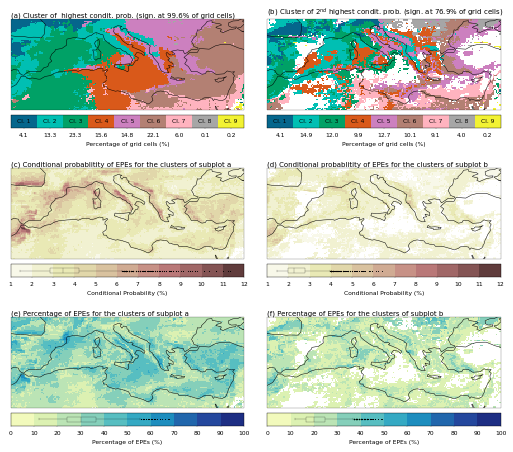

In [69]:
Fig6 = Fig6_type(dataset_used='ERA5', perc_used=99)
Fig6.savefig(results_loc+'Pdf/Fig6.pdf')
Fig6.savefig(results_loc+'Png/Fig6.png', dpi=1200, transparent=True)
del(Fig6)

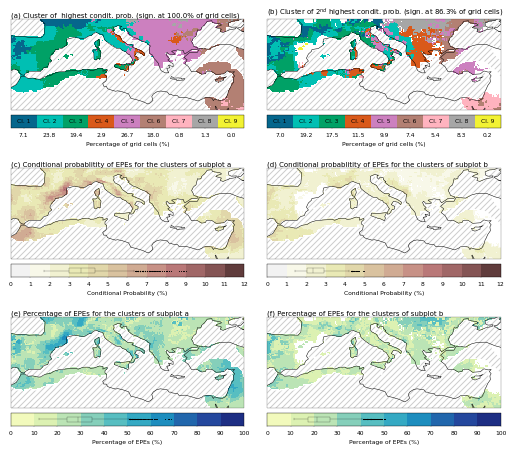

In [70]:
FigA1 = Fig6_type(dataset_used='EOBS', perc_used=99)
FigA1.savefig(results_loc+'Pdf/FigA1.pdf')
FigA1.savefig(results_loc+'Png/FigA1.png', dpi=1200, transparent=True)
del(FigA1)

### Figure S5/S8 (ERA5 & EOBS)<a name="FigS5"></a>

In [71]:
def FigS5_type(dataset_used):
    
    data_used = ClustersReordered[dataset_used].copy(deep=True)
    Percentiles = data_used.percentile.values 
    Percentiles = np.sort(Percentiles)
    
    NANs = ClustersStatsAll[dataset_used][0][0][0] # get locations of NANs(lat/lon) from first slice of xarray
    NANs = np.isnan(NANs)

    all_locs_len = (NANs==0).sum().values # locations after excluding areas of NaN (check script 3 for EOBS)

    Cond_cols_used = Cond_colorbar[dataset_used]['Colors']
    Cond_vals_used = Cond_colorbar[dataset_used]['Values']

    fig, ax_all = plt.subplots(3, 3, figsize=(18/2.54, 12/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    # plot the best clusters
    for i, j in enumerate([0,1,2]):

        cluster_data_actual = data_used.sel(indicator='Cluster', order=0, percentile=Percentiles[i]).values
        cluster_data = cluster_data_actual+1 # add one so that all clusters have integer positive values
        Sign_Sorted = data_used.sel(indicator='Significance', order=0, percentile=Percentiles[i]).values
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        cluster_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
        cluster_plot = ax_all[j].pcolor(X_all, Y_all, cluster_data, transform=ccrs.PlateCarree(), 
                                        norm=BoundaryNorm(np.insert(Cl_vals_used+1, 0, -1), len(Cl_cols_used)+1), 
                                        cmap=ListedColormap(['white']+Cl_cols_used)) # same idea as Figure 7


        sign_values = cluster_data_actual.flatten()[~(Sign_Sorted != 1).flatten()] # keep only significant locations
        sign_perc = np.round(len(sign_values)/all_locs_len*100, 1)
        title_used = ['(a)', '(b)', '(c)'][i] + ' MCP cluster (sign. at {:.1f}% grid cells)'.format(sign_perc)
        ax_all[j].set_title(title_used, size=7, pad=2, loc='left')
        ax_all[j].text(0.5, 1.25, 'P{} EPEs'.format(Percentiles[i]), fontsize=9, ha='center', 
                       transform = ax_all[j].transAxes)

        # add informative colorbar
        Counts = pd.Series(sign_values).value_counts()
        Counts = Counts.reindex(Cl_vals_used[:-1]).fillna(0)
        Counts = np.round(Counts/all_locs_len*100, 1).astype(str)
        plot_discrete_bar_inset(col_lims=Cl_vals_used, col_used=Cl_cols_used, data_used=Counts, 
                                ax=ax_all[j], brdpad=-2, loc=8,
                                cat_names=['Cl. '+str(i) for i in list(Cl_vals_used[1:])], col_text='black',
                                width='100%', height='15%', xlabel='Percentage of grid cells (%)')


    # plot conditional probabilities of the best 2 clusters
    for i, j in enumerate([3,4,5]):

        cond_data = data_used.sel(indicator='Cond_over_Nom', order=0, percentile=Percentiles[i]).values
        Sign_Sorted = data_used.sel(indicator='Significance', order=0, percentile=Percentiles[i]).values
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        cond_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
        cond_plot = ax_all[j].pcolor(X_all, Y_all, cond_data, transform=ccrs.PlateCarree(), 
                                     norm=BoundaryNorm(np.insert(Cond_vals_used, 0, -1), len(Cond_cols_used)+1),
                                     cmap=ListedColormap(['white']+Cond_cols_used)) 

        title_used = ['(d)', '(e)', '(f)'][i] + ' MCP over Nominal Probability'
        ax_all[j].set_title(title_used, size=7, pad=2, loc='left')
        
        # add informative colorbar
        cond_values = cond_data.flatten()[~(Sign_Sorted != 1).flatten()]
        plot_continuous_bar_inset(col_lims=Cond_vals_used, col_used=Cond_cols_used, data=cond_values, ax=ax_all[j], 
                                  width='100%', height='15%', loc=8, brdpad=-2, xlabel='MCP over Nominal Probability')


    # plot % of EPE for the best 2 clusters
    Perc_vals_used = np.linspace(0, 100, 11) # Percentages plot between 0-100% with 10 colors   
    Perc_cols_used = sns.color_palette('YlGnBu', n_colors=10)
    for i, j in enumerate([6,7,8]): 

        ratio_data = data_used.sel(indicator='PercExtremes', order=0, percentile=Percentiles[i]).values
        Sign_Sorted = data_used.sel(indicator='Significance', order=0, percentile=Percentiles[i]).values
        # if masked data used then white areas (no sign.) get border lines; workaround: add color/value at start
        ratio_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
        perc_plot = ax_all[j].pcolor(X_all, Y_all, ratio_data, transform=ccrs.PlateCarree(), 
                                     norm=BoundaryNorm(np.insert(Perc_vals_used, 0, -1), len(Perc_vals_used)+1),
                                     cmap=ListedColormap(['white']+Perc_cols_used)) 


        title_used = ['(g)', '(h)', '(i)'][i] + ' Percentage of EPEs for the MCP cluster'
        ax_all[j].set_title(title_used, size=7, pad=2, loc='left')
        
        # add informative colorbar
        perc_values = ratio_data.flatten()[~(Sign_Sorted != 1).flatten()]
        plot_continuous_bar_inset(col_lims=Perc_vals_used, col_used=Perc_cols_used, data=perc_values, ax=ax_all[j], 
                                  width='100%', height='15%', loc=8, brdpad=-2, xlabel='Percentage of EPEs (%)')    

    for ax in ax_all: # set for all subplots the cartopy map and the extent
        if (NANs==True).sum()>0: # hatch NaN locs (only valid for EOBS data)
            plt_NANs = ax.contourf(X, Y, NANs.where(NANs==True), hatches=['////'], colors='white')
            plt_NANs.collections[0].set_edgecolor('.8')
            plt_NANs.collections[0].set_linewidth(0.)  

        ax.coastlines(resolution='110m', linewidth=.5, color='black')
        ax.outline_patch.set_linewidth(.2) # reduce the border thickness
        ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())

    plt.subplots_adjust(left=0.02, bottom=0.05, right=.98, top=.99, hspace=.05, wspace=0.1)
    
    return fig

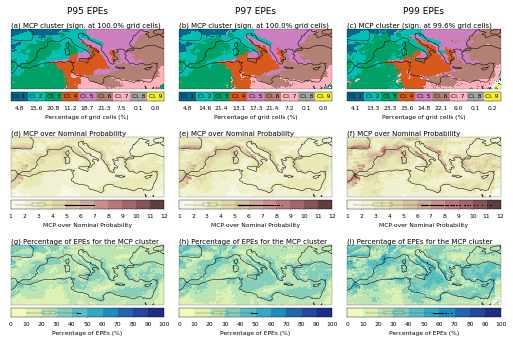

In [72]:
FigS5 = FigS5_type('ERA5')
FigS5.savefig(results_loc+'Pdf/FigS5.pdf')
FigS5.savefig(results_loc+'Png/FigS5.png', dpi=1200, transparent=True)
del(FigS5)

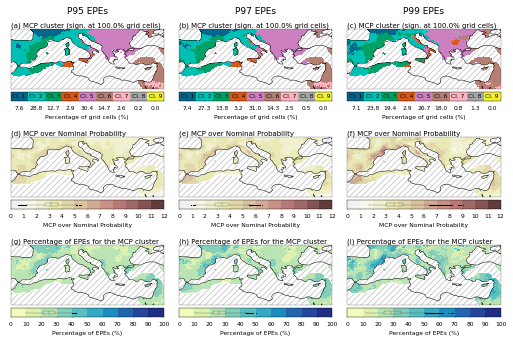

In [73]:
FigS8 = FigS5_type('EOBS')
FigS8.savefig(results_loc+'Pdf/FigS8.pdf')
FigS8.savefig(results_loc+'Png/FigS8.png', dpi=1200, transparent=True)
del(FigS8)

### Graphical Abstract<a name="GA"></a>

In [74]:
def graphical_abstract(perc_used):
    
    data_used = ClustersReordered['ERA5'].copy(deep=True)
    data_used = data_used.sel(percentile=perc_used)
    
    NANs = ClustersStatsAll['ERA5'][0][0][0] # get locations of NANs(lat/lon) from first slice of xarray
    NANs = np.isnan(NANs)

    all_locs_len = (NANs==0).sum().values # locations after excluding areas of NaN (check script 3 for EOBS)

    Cond_cols_used = Cond_colorbar['ERA5']['Colors']
    Cond_vals_used = Cond_colorbar['ERA5']['Values'] 
    
    fig, ax_all = plt.subplots(2, 1, figsize=(5/2.54, 5.5/2.54), subplot_kw={'projection': ccrs.PlateCarree()})
    ax_all = ax_all.flatten()

    for ax in ax_all: # set for all subplots the cartopy map and the extent
        ax.coastlines(resolution='110m', linewidth=.5, color='black')
        ax.outline_patch.set_linewidth(.2) # reduce the border thickness
        ax.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())

    # cluster of MCP   
    cluster_data_actual = data_used.sel(indicator='Cluster', order=0).values
    cluster_data = cluster_data_actual+1 # add one so that all clusters have integer positive values
    Sign_Sorted = data_used.sel(indicator='Significance', order=0).values
    
    # if masked data used then white areas (no sign.) get border lines; workaround with adding color/value at start
    cluster_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
    cluster_plot = ax_all[0].pcolor(X_all, Y_all, cluster_data, transform=ccrs.PlateCarree(), 
                                    norm=BoundaryNorm(np.insert(Cl_vals_used+1, 0, -1), len(Cl_cols_used)+1), 
                                    cmap=ListedColormap(['white']+Cl_cols_used)) # same idea as Figure 7


    sign_values = cluster_data_actual.flatten()[~(Sign_Sorted != 1).flatten()] # keep only significant locations
    ax_all[0].set_title('Cluster of Maximum Conditional Probability (MCP)', size=5, pad=2, loc='left')

    # add informative colorbar
    Counts = pd.Series(sign_values).value_counts()
    Counts = Counts.reindex(Cl_vals_used[:-1]).fillna(0)
    Counts = np.round(Counts/all_locs_len*100, 2).astype(str)
    ax_sub = plot_discrete_bar_inset(col_lims=Cl_vals_used, col_used=Cl_cols_used, data_used=Counts, ax=ax_all[0], 
                                     brdpad=-1.5, loc=8, cat_names=['Cl. '+str(i) for i in list(Cl_vals_used[1:])], 
                                     col_text='black', width='100%', height='15%', xlabel='', bar_text_size=4.5)
    ax_sub.set_xticks([])


    # MCP
    cond_data = data_used.sel(indicator='Cond_over_Nom', order=0).values
    Sign_Sorted = data_used.sel(indicator='Significance', order=0).values
    
    # if masked data used then white areas (no sign.) get border lines; workaround with adding color/value at start
    cond_data[Sign_Sorted!=1] = -.5 # mask non significant locations with negative value
    cond_plot = ax_all[1].pcolor(X_all, Y_all, cond_data, transform=ccrs.PlateCarree(), 
                                 norm=BoundaryNorm(np.insert(Cond_vals_used, 0, -1), len(Cond_cols_used)+1),
                                 cmap=ListedColormap(['white']+Cond_cols_used)) 

    ax_all[1].set_title('Ratio of MCP over Nominal Probability', size=5, pad=2, loc='left')

    # add informative colorbar
    cond_values = cond_data.flatten()[~(Sign_Sorted != 1).flatten()]
    ax_sub = plot_continuous_bar_inset(col_lims=Cond_vals_used, col_used=Cond_cols_used, data=cond_values, 
                                       ax=ax_all[1], width='100%', height='15%', loc=8, brdpad=-1.5, xlabel='')
    ax_sub.set_xticklabels(labels=range(1,13), size=4.5)

    plt.subplots_adjust(left=0.02, bottom=0.07, right=.98, top=1, hspace=.0, wspace=0.)
    return fig

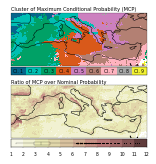

In [75]:
GraphicalAbstract = graphical_abstract(perc_used=99)
GraphicalAbstract.savefig(results_loc+'Pdf/GraphicalAbstract.pdf')
GraphicalAbstract.savefig(results_loc+'Png/GraphicalAbstract.png', dpi=1200, transparent=True)
del(GraphicalAbstract)

In [76]:
del(Cl_cols_used, Cl_vals_used, ClustersReordered, ClustersStatsAll, Cond_colorbar, Fig6_type, Fig7_type, FigS5_type,
    X, X_all, Y, Y_all, graphical_abstract)